### Challenge Data Scientist - Neuralworks
#### Problema a resolver
Predecir la probabilidad de atraso de los vuelos que aterrizan o despegan del aeropuerto de Santiago de Chile (SCL).

#### Dependencias

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import plotly.express as px
import datetime

#### Distribución de los datos
Importamos los datos y hacemos los primeros chequeos de la distribución, completitud y tipo de los datos.

In [40]:
df = pd.read_csv('dataset_SCL.csv', dtype={'Fecha-I':'str', 'Vlo-I': 'str', 'Ori-I': 'str', 'Des-I':'str', 'Emp-I': 'str',
'Fecha-O': 'str', 'Vlo-O': 'str', 'Ori-O': 'str','Des-O': 'str', 'Emp-O': 'str', 
'DIA': 'int', 'MES': 'int','AÑO': 'int', 'DIANOM': 'str', 
'TIPOVUELO': 'str', 'OPERA': 'str', 'SIGLAORI': 'str', 'SIGLADES': 'str'},parse_dates=['Fecha-I','Fecha-O'])

Revisamos la completitud del dataset con `msno`:

<AxesSubplot:>

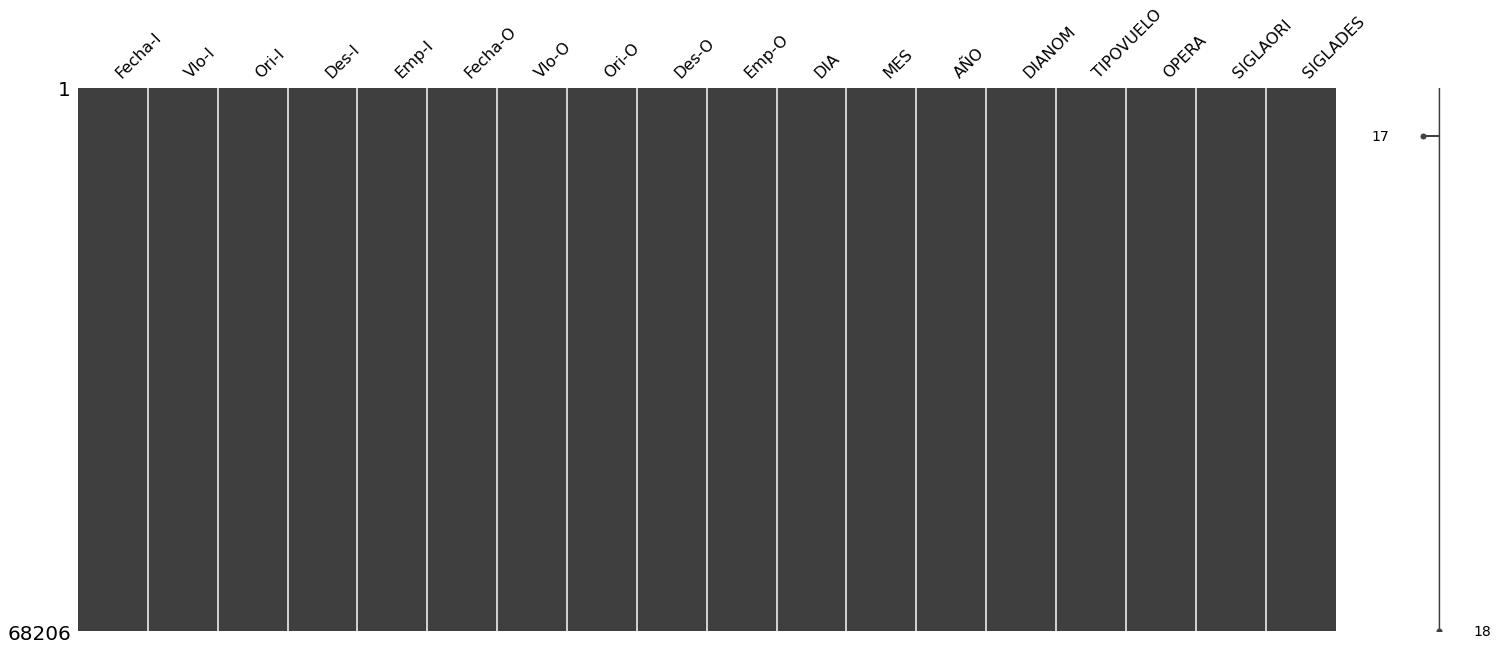

In [43]:
msno.matrix(df)

Notamos que hay un registro con valor nulo, por lo que exploramos en detalle:

In [44]:
df[df.isna().any(axis=1)]

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Revisamos si hay otros vuelos con las mismas características con el que podríamos inferir qué es ese valor faltane para imputarlo.

In [45]:
df.query('OPERA == "Latin American Wings" & SIGLADES == "Lima" & `Emp-O` == "56R" & `Vlo-I` == "200"', engine = 'python')

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6067,2017-01-18 11:00:00,200,SCEL,SPJC,LAW,2017-01-18 11:06:00,200,SCEL,SPJC,56R,18,1,2017,Miercoles,I,Latin American Wings,Santiago,Lima
6068,2017-01-19 11:00:00,200,SCEL,SPJC,LAW,2017-01-19 11:03:00,NaN,SCEL,SPJC,56R,19,1,2017,Jueves,I,Latin American Wings,Santiago,Lima


Llegando a esto, podríamos tomar dos caminos: 
1) Inputar el valor de Vlo-O con "200", asumiendo sin mayor contexto que sería lo correcto
2) Descartar el dato dado que es ínfimo respecto al resto del dataset
3) Consultar a la contraparte correspondiente que emitió el dato.

Dada la agilidad y naturaleza del ejercicio, lo más práctico sería 2).

In [46]:
df.drop(6068, inplace=True)

Con lo anterior listo, podemos ir directo a ver las distribuciones de los datos. Notamos eso sí, que `Vlo-I` y `Vlo-O` están interpretadas en el dataframe como `object` y no como `int`

In [47]:
df.dtypes

Fecha-I      datetime64[ns]
Vlo-I                object
Ori-I                object
Des-I                object
Emp-I                object
Fecha-O      datetime64[ns]
Vlo-O                object
Ori-O                object
Des-O                object
Emp-O                object
DIA                   int32
MES                   int32
AÑO                   int32
DIANOM               object
TIPOVUELO            object
OPERA                object
SIGLAORI             object
SIGLADES             object
dtype: object

Haciendo un sample nos damos cuenta que hay algunos valores que son enteros y se interpretaron con un formato decimal, por lo que tenemos que hacernos cargo de esos casos borde.

In [8]:
df[['Vlo-I', 'Vlo-O']].sample(10)

,Vlo-I,Vlo-O
54696,632,632
66004,324,324.0
35494,174,174
40906,118,118
53489,302,302
54496,532,532
41601,215,215
19324,118,118
19413,126,126
17672,174,174


Explorando los datos, nos damos cuenta también de que hay números de vuelo con letras que no son necesariamente errores, entonces hay que tener cuidado al hacer la transformación de los valores mencionados anteriormente.

Por lo tanto, buscamos todos los valores "convertibles a numérico" y buscamos con un Regex si contienen un decimal dentro de su cadena, reemplazándolo por un string vacío, de esta manera asegurándonos que 324 y 324.0 sean lo mismo para los análisis y modelos que usemos después.

In [48]:
df.loc[pd.to_numeric(df['Vlo-I'], errors='coerce').notnull(), 'Vlo-I'] = pd.to_numeric(df['Vlo-I'], errors='coerce').astype('int', errors='ignore').astype('str').replace('\.\d+', '', regex=True)
df.loc[pd.to_numeric(df['Vlo-O'], errors='coerce').notnull(), 'Vlo-O'] = pd.to_numeric(df['Vlo-O'], errors='coerce').astype('int', errors='ignore').astype('str').replace('\.\d+', '', regex=True)

Nos aseguramos que el error haya desaparecido:

In [53]:
df.query("`Vlo-I` == '324' & `Vlo-O` == '324.0'", engine = "python")

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


Con el wrangling listo, podemos partir con la gráfica de las distribuciones de los datos:

In [129]:
def plot_categories(df: pd.DataFrame, variable_name: str, variable_name_plot:str, width: int = 6, height: int = 3):
    """Esta función recibe los parámetros df, variable_name, variable name plot, length y height, de manera
    de no tener que repetir código teniendo un estilo ya más o menos definido."""
    
    sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
    sns.set_style("whitegrid")
    # Set figure size (width, height) in inches
    fig, ax = plt.subplots(figsize = ( width , height ))
    p = sns.countplot(x = df[variable_name], ax= ax).set(title=f'Distribución de vuelos por {variable_name_plot}.')
    ax.set_xlabel(variable_name_plot, size = 12)
    ax.set_ylabel("Nº de vuelos", size = 12)
    plt.xticks(rotation = 90)
    return p

Podemos observar que la mayoría de las aerolíneas del dataset son de Grupo LATAM y Sky Airline, lo que nos podría servir para hacer un encoding y balanceo de esta feature al desarrollar el modelo.

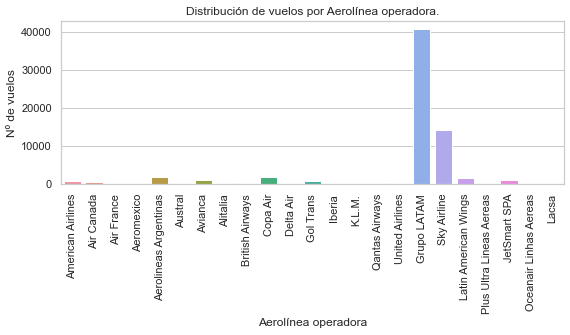

In [130]:
plt.show(plot_categories(df = df, variable_name= 'OPERA',variable_name_plot = 'Aerolínea operadora', width = 9, height = 3))

##### Revisión de las variables categóricas.
Primero que nada, revisamos la consistencia entre los datos programados y los de operación.
Naturalmente, los códigos de los orígenes nunca cambian, ya que sería muy raro o casi imposible que pasajeros tengan que cambiarlos de aeropuerto para poder tomar su vuelo.

In [76]:
df.query("`Ori-I` != `Ori-O`", engine = 'python')

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES


Luego, con los códigos de vuelo llama la atención de que hay un grupo reducido de vuelos en el que el código de vuelo programado difiere del código de vuelo del de operación, este dato podría ser interesante, ya que se pueden ver que hay en algunos casos retrasos considerables, como en el caso de la fila 6018, que tuvo un atraso de 2 horas y media. Esta intuición la podremos verificar cuando visualizemos la diferencia entre Fecha-O y Fecha-I.

In [72]:
df.query("`Vlo-I` != `Vlo-O`", engine = 'python')

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
6018,2017-01-05 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-05 09:36:00,1001,SCEL,SAEZ,LAN,5,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6020,2017-01-07 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-07 06:59:00,1001,SCEL,SAEZ,LAN,7,1,2017,Sabado,I,Grupo LATAM,Santiago,Buenos Aires
6022,2017-01-12 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-12 08:05:00,1003,SCEL,SAEZ,LAN,12,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
6023,2017-01-13 07:05:00,4501,SCEL,SAEZ,LAN,2017-01-13 07:06:00,1001,SCEL,SAEZ,LAN,13,1,2017,Viernes,I,Grupo LATAM,Santiago,Buenos Aires
6025,2017-01-19 10:50:00,4501,SCEL,SAEZ,LAN,2017-01-19 10:56:00,1001,SCEL,SAEZ,LAN,19,1,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60565,2017-11-05 22:10:00,530,SCEL,SPJC,LAN,2017-11-05 22:24:00,534,SCEL,SPJC,LAN,5,11,2017,Domingo,I,Grupo LATAM,Santiago,Lima
61354,2017-11-09 11:20:00,7811,SCEL,SAEZ,LAN,2017-11-09 12:23:00,1103,SCEL,SAEZ,LAN,9,11,2017,Jueves,I,Grupo LATAM,Santiago,Buenos Aires
61426,2017-11-05 16:30:00,207,SCEL,SCIE,LXP,2017-11-05 18:22:00,207R,SCEL,SCIE,LXP,5,11,2017,Domingo,N,Grupo LATAM,Santiago,Concepcion
62175,2017-12-20 19:25:00,2287,SCEL,SAEZ,ARG,2017-12-20 20:17:00,1287,SCEL,SAEZ,AUT,20,12,2017,Miercoles,I,Aerolineas Argentinas,Santiago,Buenos Aires


Observamos que el código del destino también cambia en un tamaño reducido (28) de vuelos, lo que revisaremos más adelante para revisar si significa algo o no (hay algunos que tienen retrasos hasta de 2 horas y media).

In [80]:
print(df.query("`Des-I` != `Des-O`", engine = 'python').shape)
df.query("`Des-I` != `Des-O`", engine = 'python').head()

(28, 18)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
1397,2017-01-17 19:20:00,25,SCEL,SCTE,SKU,2017-01-17 19:46:00,25,SCEL,SCQP,SKU,17,1,2017,Martes,N,Sky Airline,Santiago,Temuco
7290,2017-02-15 06:25:00,11,SCEL,SCTE,SKU,2017-02-15 06:25:00,11,SCEL,SCQP,SKU,15,2,2017,Miercoles,N,Sky Airline,Santiago,Temuco
7520,2017-02-27 06:40:00,71,SCEL,SCIE,SKU,2017-02-27 09:07:00,71,SCEL,SCQP,SKU,27,2,2017,Lunes,N,Sky Airline,Santiago,Temuco
8456,2017-02-15 06:10:00,57,SCEL,SCTE,LAN,2017-02-15 06:12:00,57,SCEL,SCQP,LAN,15,2,2017,Miercoles,N,Grupo LATAM,Santiago,Temuco
12787,2017-03-18 06:25:00,11,SCEL,SCTE,SKU,2017-03-18 06:29:00,11,SCEL,SCQP,SKU,18,3,2017,Sabado,N,Sky Airline,Santiago,Temuco


En el caso del código de la aerolínea del vuelo programado, esta diferencia entre códigos es más prominente (casi 1/3 del dataset). Este caso podría ser más común pero de igual forma aperturaremos la diferencia de los timestamps para poder evaluar si es un insight relevante o no.

In [81]:
print(df.query("`Emp-I` != `Emp-O`", engine = 'python').shape)
df.query("`Emp-I` != `Emp-O`", engine = 'python').head()

(18668, 18)


,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
345,2017-01-21 22:30:00,2291,SCEL,SABE,AUT,2017-01-21 22:28:00,2291,SCEL,SABE,ARG,21,1,2017,Sabado,I,Austral,Santiago,Buenos Aires
814,2017-01-01 07:14:00,624,SCEL,SPJC,AVA,2017-01-01 07:11:00,624,SCEL,SPJC,LRC,1,1,2017,Domingo,I,Avianca,Santiago,Lima
815,2017-01-02 07:00:00,624,SCEL,SPJC,AVA,2017-01-02 07:05:00,624,SCEL,SPJC,LRC,2,1,2017,Lunes,I,Avianca,Santiago,Lima
816,2017-01-03 07:14:00,624,SCEL,SPJC,AVA,2017-01-03 07:14:00,624,SCEL,SPJC,LRC,3,1,2017,Martes,I,Avianca,Santiago,Lima
817,2017-01-04 07:00:00,624,SCEL,SPJC,AVA,2017-01-04 07:24:00,624,SCEL,SPJC,LRC,4,1,2017,Miercoles,I,Avianca,Santiago,Lima


No pareciera haber un gran desbalance en la cantidad de vuelos que operan por día de semana, aunque vale notar que el sábado es el con menor cantidad. Para sacar mayores conclusiones habrá que graficar cómo se comporta el target con esta variable.

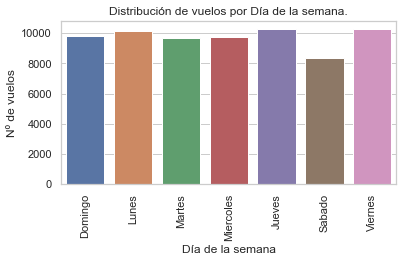

In [132]:
plt.show(plot_categories(df = df, variable_name= 'DIANOM',variable_name_plot = 'Día de la semana', width = 6, height = 3))

En cuanto a los destinos, primero revisamos cuántos de estos son nacionales y cuantos internacionales, en lo que podemos notar que están casi mitad y mitad. Dependiendo de lo que desarrollemos más adelante, uno podría proponer tener dos modelos distintos ya que ambos tipos de vuelos pueden tener naturalezas distintas.

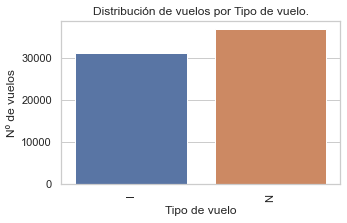

In [133]:
plt.show(plot_categories(df = df, variable_name= 'TIPOVUELO',variable_name_plot = 'Tipo de vuelo', width = 5, height = 3))

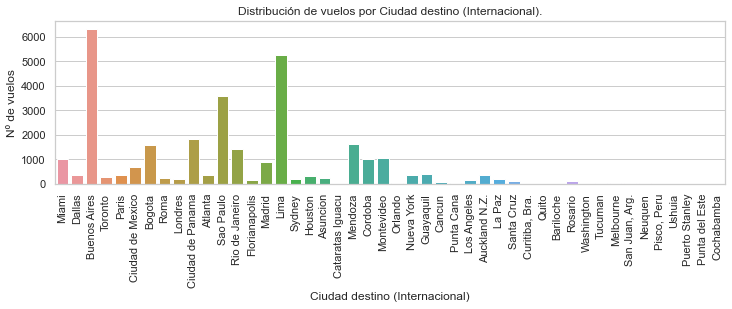

In [134]:
plt.show(plot_categories(df = df.query("TIPOVUELO == 'I'", engine = 'python'), variable_name= 'SIGLADES',variable_name_plot = 'Ciudad destino (Internacional)', width = 12, height = 3))

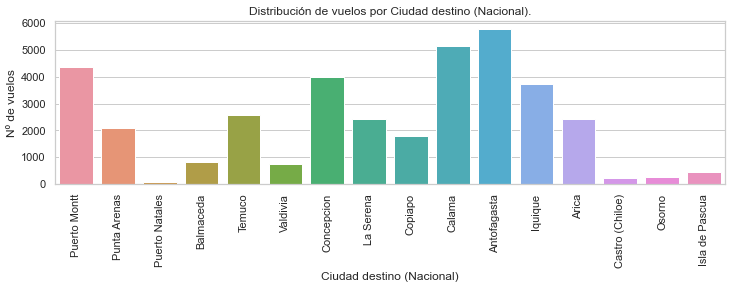

In [135]:
plt.show(plot_categories(df = df.query("TIPOVUELO == 'N'", engine = 'python'), variable_name= 'SIGLADES',variable_name_plot = 'Ciudad destino (Nacional)', width = 12, height = 3))

Observamos que el dataset está bastante balanceado para dias de mes, mes y año (y notamos que la data es casi exclusivamente del 2017). En cualquier caso, si se deseara productivizar el modelo para detectar demoras en los vuelos, se debería considerar como mínimo 1 año de datos para poder capturar la estacionalidad, al mismo tiempo que teniendo consideraciones de no mirar mucho hacia atrás (o de ser el caso, tener variables que permitan capturar una relevancia distinta o cambios (como la pandemia, por ejemplo)).

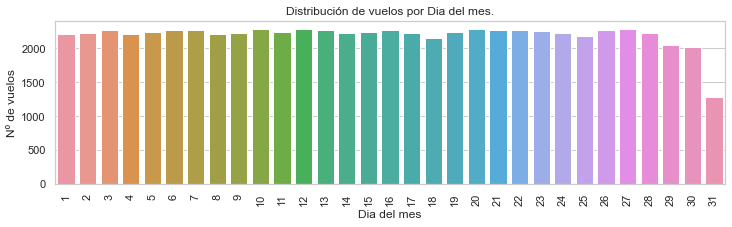

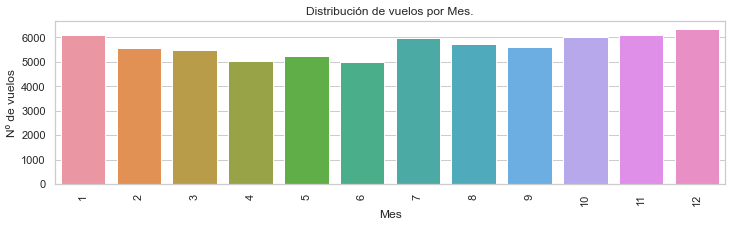

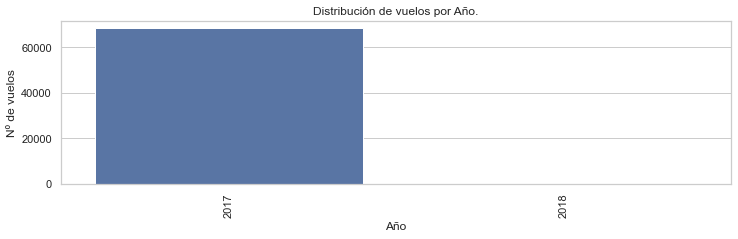

In [136]:
plt.show(plot_categories(df = df, variable_name= 'DIA',variable_name_plot = 'Dia del mes', width = 12, height = 3))
plt.show(plot_categories(df = df, variable_name= 'MES',variable_name_plot = 'Mes', width = 12, height = 3))
plt.show(plot_categories(df = df, variable_name= 'AÑO',variable_name_plot = 'Año', width = 12, height = 3))

#### Generación de columnas adicionales y visualización de target
Generamos las siguientes columnas:
* `temporada_alta`: 1 si `Fecha-I` está entre: 15 de Diciembre y 3 de Marzo | 15 de Julio y 31 de Julio | 11 de Septiembre y 30 de Septiembre y 0 si no.
* `dif_min`: diferencia en minutos entre `Fecha-I` y `Fecha-O`.
* `atraso_15`: 1 si `diff_min` > 15, 0 si no.
* `periodo_dia`: "mañana" si componente tiempo de `Fecha-I` está entre 5:00 y 11:59, "tarde", si está entre 12:00 y 18:59, o "noche" si está entre 19:00 y 4:59.

In [177]:
def temporada_alta(row):
    #Inicio t1: 15 del 12, Término t1: 3 del 4
    if ((row.MES == 12 and row.DIA >= 15) or (row.MES in [1, 2]) or (row.MES == 3 and row.DIA <= 3)):
        is_temporada_alta = 1
    elif row.MES == 7 and (row.DIA >= 15 and row.DIA <= 31):#Inicio t2: 15 del 7, Término t2: 31 del 7
        is_temporada_alta = 1
    elif row.MES == 9 and (row.DIA >= 11 and row.DIA <= 30):#Inicio t3: 11 del 9, Término t3: 30 del 9
        is_temporada_alta = 1
    else: 
        is_temporada_alta = 0
    return is_temporada_alta

def periodo_dia(row):
    if row['Fecha-I'].time()  >= datetime.time(5,0,0) and row['Fecha-I'].time()  < datetime.time(12,0,0):
        periodo = 'mañana'
    elif row['Fecha-I'].time()  >= datetime.time(12,0,0) and row['Fecha-I'].time()  < datetime.time(19,0,0):
        periodo = 'tarde'
    else:
        periodo = 'noche'
    return periodo

df.loc[:, 'temporada_alta'] = df.apply(temporada_alta, axis = 1)
df.loc[:, 'diff_min'] = (df['Fecha-O'] - df['Fecha-I']).dt.total_seconds()/60.0
df.loc[:, 'atraso_15'] = df.loc[:, 'diff_min'].apply(lambda x: 1 if x >= 15 else 0)
df.loc[:, 'periodo_dia'] = df.apply(periodo_dia, axis = 1)

Observamos que aproximadamente un 20% de los vuelos tienen atrasos de más de 15 minutos. Tendremos que tener en cuenta este desbalance al momento de formular el problema más adelante.

0    54589
1    13616
Name: atraso_15, dtype: int64


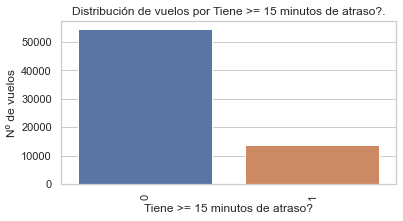

In [162]:
print(df.loc[:, 'atraso_15'].value_counts())
plt.show(plot_categories(df = df, variable_name= 'atraso_15', variable_name_plot= 'Tiene >= 15 minutos de atraso?'))

Observamos que la mayoría de los vuelos ocurre fuera de temporada alta, 

0    45444
1    22761
Name: temporada_alta, dtype: int64


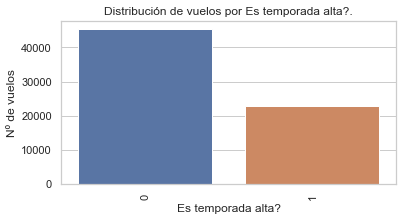

In [163]:
print(df.loc[:, 'temporada_alta'].value_counts())
plt.show(plot_categories(df, 'temporada_alta', variable_name_plot='Es temporada alta?'))

tarde     25506
mañana    25351
noche     17348
Name: periodo_dia, dtype: int64


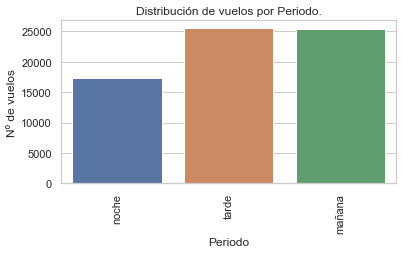

In [178]:
print(df.loc[:, 'periodo_dia'].value_counts())
plt.show(plot_categories(df, 'periodo_dia', variable_name_plot='Periodo'))

#### Exploración de la distribución del target por categoría

#### Implementación de modelo(s) de machine learning

#### Evaluación de los modelos de machine learning